<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

# Construction d'un auto-encodeur avec Keras

<P style="text-align:center"><img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" style="float:center; display: inline" alt="schema"/></P>
*Architecture d'un autoencoder*

## 1. Objectif
#### i. Présentatation générale

L'objectif de ce TP est de construire un auto-encodeur. Un auto-encodeur est un algorithme de compression des données dont les fonctions de compression et décompression reposent sur 3 caratéristiques principales :

* il est **spécifique aux données**, c'est-à-dire qu'il n'est construit que pour un seul type de donnée à la fois, ainsi il ne sera capable de traiter que des données similaires à celles sur lesquelles il s'est entrainé. Cela s'explique de par le fait que les features qu'il aura appris seront propres au type de données qu'il aura traité. 

* il est **à perte**, c'est-à-dire que comme tout compresseur, il fait perdre de leur qualité aux données en sortie par rapport à celles en entrée.
* il est **à apprentissage** : c'est un réseau de neurones donc il a besoin d'exemples de données pour fonctionner.


Pour construire un tel algorithme, il nous faut 3 éléments précis : une **fonction de codage**, une **fonction de décodage** et une **fonction de distance ou fonction de "loss"** (cette dernière permet de calculer la quantité d'information perdue lors de la compression).

Les fonctions de **codage** et de ** décodage** seront des réseaux de neurones différentiable par rapport à la fonction de perte, de manière à ce que les paramètres du codage/décodage puissent être optimisés de sorte que l'on minimise la perte lors de la phase de reconstruction.  

Ce type d'auto-encodeur est très peu utilisé aujourd'hui principalement à cause de sa spécificité aux données.Mais, l'auto-encoding a été longtemps considéré comme un moyen potentiel de résoudre le problème de l'apprentissage non-supervisé ie l'apprentissage sans labels.

L'auto-encoding n'est pas une technique de supervisation d'apprentissage mais plutôt une auto-supervisation (car gènère la valeur souhaitée (target) à partir de l'entrée qui lui a été fournie).

Dans le but de permettre à l'auto-encoder d'apprendre des features intéressantes, on doit lui fournir d'intéressantes target and loss fonctions. 

#### ii. Sum-up

Un **autoencoder** est donc un **réseau de neurones** dont le but est de faire correspondre  ces entrées à ces sorties (sorte de recopie). 

Cela va se faire dans un premier temps par la compression de l'entrée dans une représentation en **espace latent** (latent space est un espace permettant de capturer les features principales des données que l'on traite). Puis dans un second temps on va reconstruire la sortie à partir de la représentation obtenue (représentation dans l'espace latent). 

Comme l'indique le schéma ci-dessus l'autoencoder est composé de deux parties : 

* **Encoder** qui compresse l'entrée dans l'espace latent. 
* **Decoder** qui reconstruit l'entrée à partir de la représentation dans l'espace latent.  

Afin de faire en sorte que l'utilité d'un autoencoder ne soit pas réduite à une simple tâche de recopie on peut limité la taille de la **" compressed representation" ** de sorte qu'elle soit de taille plus petite que celle de l'entrée ainsi cette représentation force l'autoencoder à apprendre que les caractéristiques pertinentes des données. 



## 2. Mise en pratique

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

/usr/local/insa/anaconda/envs/GPU/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


L'objectif ici est de compresser l'image, dont la taille de départ est de 784. Le facteur de compression est de 24,5 : on obtient donc comme taille finale 784/24,5 = 32. Ainsi, la première étape est de donner au réseau de neurône l'image en entrée, en spécifiant sa taille, et d'utiliser la **fonction de codage** sur cette image en entrée. Pour le moment, aucune opération n'est réalisée, on a définie le graphe. On rappelle ici que la fonction **relu** est définie de la façon suivante :

$$relu(x) = max(0,x)$$

et la fonction sigmoid est quant-à-elle définie par :

$$sigmoid(x) = \frac{1}{1+\text{e}^x}$$

à valeurs dans $[0,1]$. Ainsi, on utilise pour décoder la fonction **sigmoid** afin d'obtenir des valeurs de probabilités.

In [21]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [22]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

## Explication des 2 codes précédents???

In [23]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [28]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [29]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [11]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.3629 - val_loss: 0.2725
Epoch 2/50
60000/60000 [==============================] - 3s 49us/step - loss: 0.2671 - val_loss: 0.2583
Epoch 3/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.2476 - val_loss: 0.2337
Epoch 4/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2251 - val_loss: 0.2140
Epoch 5/50
60000/60000 [==============================] - 3s 56us/step - loss: 0.2084 - val_loss: 0.2002
Epoch 6/50
60000/60000 [==============================] - 4s 69us/step - loss: 0.1968 - val_loss: 0.1904
Epoch 7/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.1881 - val_loss: 0.1826
Epoch 8/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.1809 - val_loss: 0.1763
Epoch 9/50
60000/60000 [==============================] - 4s 62us/step - loss: 0.1748 - val_loss: 0.1706
Epoch

In [12]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

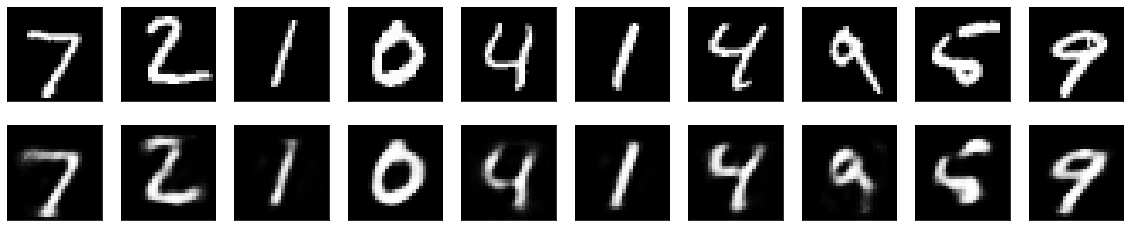

In [17]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)